# Libraries

In [18]:
# import csv
# import os
# import re
import json
import umap

import hdbscan
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Dataset

In [19]:
# query = "Query_NYT_5y_surveillance"
query = "Query_NYT_13y_surveillance"
# query = "Query_US_5y_Svalbard"

FEATHER_FILE = query + ".feather"

df = pd.read_feather('data/' + FEATHER_FILE)
# df = df.drop(df[df['tags'].str.contains('None') == True].index)
# df = df.reset_index(drop=True)
df = df.drop('text_downloaded', axis=1)
df = df.drop('stories_id', axis=1)

df.sample(3)

,title,url,year,text,tags,GPE,IND,ORG
363,"U.S. Finds Cuba Speeding Build-Up of Bases, Wa...",https://archive.nytimes.com/www.nytimes.com/bo...,2019,"|\n|\nOctober 27, 1962\nU.S. Finds Cuba Speedi...","[{'label': 'armament, defense and military for...","[U.S., Cuba, Shun Blockade Zone, New York, Tim...","[Khrushchev, Kennedy, Adlai E. Stevenson, Kenn...","[White House, U Thant, the United Nations, Dir..."
1769,Another Mental Illness Tragedy Spurs Questions...,https://www.nytimes.com/2023/03/23/us/irvo-oti...,2023,Supported by\nAnother Mental Illness Tragedy S...,"[{'label': 'deaths', 'score': '0.73499'}, {'la...","[Virginia, Richmond, Va., Virginia, Petersburg...","[Marcus-David Peters, Irvo Otieno, Otieno, Pri...","[Health System\nIrvo Otieno, Central State Hos..."
3095,"For New Idea Society, a New Dimension",http://tmagazine.blogs.nytimes.com/2011/01/05/...,2011,The Brooklyn-based indie pop band New Idea Soc...,"[{'label': 'music', 'score': '0.97226'}, {'lab...","[Brooklyn, Iran, Iran]","[Andy LeMaster, Mike Law, O.K., Josh Gross, An...","[New Idea Society, New Idea Society, DSLR]"


## Cleaning

In [20]:
df = df[df['url'].apply(lambda x: 'www.nytimes.com/live/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/briefing/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/topic/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/podcast/' not in x)]
df = df.reset_index(drop=True)

df = df[df['url'].apply(lambda x: '/dealbook/' not in x)]
df = df.reset_index(drop=True)




## IND cleaning

In [21]:
for index, row in df.iterrows():

    ind = row['IND']
    # print(ind)

    ind = [a for a in ind if (' ' in a)] # remove ind without space
    ind = [a for a in ind if ('\n' not in a)] # remove ind with \n
    # print(ind)

    df.loc[index, 'IND'] = ind



## Set tags

In [22]:
all_tags = []

for index, row in df.iterrows():

    tags = []

    for i, tag in enumerate(row["tags"]):
        if i < 3:
            tags.append(tag["label"])

    all_tags.append(tags)

df['TAG'] = all_tags
df = df.drop(columns=['tags'])

df.sample()

,title,url,year,text,GPE,IND,ORG,TAG
2021,The Offshore Game of Online Sports Betting,http://www.nytimes.com/2015/10/26/us/pinnacle-...,2015,Wired for Profit\nThe Offshore Game of Online ...,"[the United States, New York City, the United ...","[Nikita S. Khrushchev, Gerard Brave, Richard A...","[Pinnacle Sports, the High Line, Chelsea, Pinn...","[gambling, computers and the internet, politic..."


## Clean Years

In [23]:
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()] # Remove cells without integer
df = df.reset_index(drop=True)

print(set(df["year"].tolist()))

{'2016', '2017', '2021', '2013', '2022', '2019', '2014', '2012', '2020', '2023', '2018', '2015', '2010', '2011'}


## Entities

In [24]:
entities = np.empty((0, 12), dtype=object)

years_template = {}

for year in sorted(set(df["year"].tolist())):
    years_template[year] = 0


def update(entity, type):  # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in df.iterrows():  # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]

    gpe = row["GPE"].tolist()
    ind = row["IND"]
    org = row["ORG"].tolist()
    tag = row["TAG"]
    
    cooccurrences = list(gpe + ind + org + tag)

    for entity in gpe:
        update(entity, "gpe")
    
    for entity in ind:
        update(entity, "ind")

    for entity in org:
        update(entity, "org")

    for entity in tag:
        update(entity, "tag")


# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype(
    {
        "name": "str",
        "type": "str",
        "frequency": "int",
        "slope": "float",
        "color": "str",
        "x": "int",
        "y": "int",
        "cluster": "int",
        "years": "object",
        "urls": "object",
        "titles": "object",
        "cooccurrences": "object",
    }
)


print("The total number of entities is", len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)

The total number of entities is 37432


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
0,China,gpe,6198,NaN,None,-1,-1,-1,"{'2010': 47, '2011': 4, '2012': 58, '2013': 15...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[Argentina, Argentina, Beijing, China, China, ..."


# Treatment

## Normalization

In [25]:
# Frequency scale

frequency = entities_all["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all["frequency_norm"] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
    entities_all.loc[index, "years_JSON"] = json.dumps(row["years"])

entities_all.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
9433,Gloria Steinem.</i,ind,1,NaN,None,-1,-1,-1,"{'2010': 0, '2011': 0, '2012': 0, '2013': 0, '...",[https://www.nytimes.com/2019/11/29/the-weekly...,[The Hunt for Jeffrey Epstein’s Hidden Files],"[Hollywood, i>“I, New York, Palm Beach, London...",0.0,"{""2010"": 0, ""2011"": 0, ""2012"": 0, ""2013"": 0, ""..."


## Filter

In [26]:
# Number of rows by type

max_gpe = 80
max_ind = 80
max_org = 80
max_tag = 60

top_gpe = (
    entities_all.loc[entities_all["type"] == "gpe"]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_gpe)
)
top_ind = (
    entities_all.loc[entities_all["type"] == "ind"]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_ind)
)
top_org = (
    entities_all.loc[entities_all["type"] == "org"]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_org)
)
top_tag = (
    entities_all.loc[entities_all["type"] == "tag"]
    .sort_values(by=["frequency"], ascending=False)
    .head(max_tag)
)

entities = pd.concat([top_gpe, top_ind, top_org, top_tag])



# min_frequency = 80

# entities = (
#     entities_all[entities_all['frequency']>min_frequency]
#     .sort_values(by=["frequency"], ascending=False)
# )

len(entities)


300

In [27]:
entities.head(3)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
0,China,gpe,6198,NaN,None,-1,-1,-1,"{'2010': 47, '2011': 4, '2012': 58, '2013': 15...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[Argentina, Argentina, Beijing, China, China, ...",1.000000,"{""2010"": 47, ""2011"": 4, ""2012"": 58, ""2013"": 15..."
4,the United States,gpe,3864,NaN,None,-1,-1,-1,"{'2010': 47, '2011': 49, '2012': 57, '2013': 2...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[China, Argentina, Argentina, Beijing, China, ...",0.623366,"{""2010"": 47, ""2011"": 49, ""2012"": 57, ""2013"": 2..."
892,Russia,gpe,2526,NaN,None,-1,-1,-1,"{'2010': 28, '2011': 4, '2012': 4, '2013': 88,...",[https://www.nytimes.com/2018/12/28/us/politic...,[Departing House Republicans Try to Keep Inves...,"[WASHINGTON, Virginia, South Carolina, Russia,...",0.407455,"{""2010"": 28, ""2011"": 4, ""2012"": 4, ""2013"": 88,..."


## Linear Regression

In [28]:
# For each entity

for i, row in entities.iterrows():

    x = list(row["years"].keys()) # Extract years
    x = [int(numeric_string) for numeric_string in x] # Set to int
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row["years"].values()) # Extract frequency
    y = np.array(y) # To Numpy (code works without this line)

    regression = LinearRegression()
    regression.fit(x, y)
    
    entities.at[i, "slope"] = regression.coef_[0] # compute linear regression


# normalization by type

scale = 1

for type in entities["type"].unique():

    selection = entities.loc[entities["type"] == type]
    mean = selection["slope"].mean() * scale
    
    for i, row in selection.iterrows():
        entities.at[i, "slope"] = row["slope"] - mean


entities.sample()


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
1723,David E. Sanger,ind,35,-0.278049,None,-1,-1,-1,"{'2010': 0, '2011': 1, '2012': 0, '2013': 2, '...",[https://www.nytimes.com/2019/01/28/us/politic...,[U.S. Formally Accuses Huawei Executive of Hel...,"[U.S., WASHINGTON, Iran, the United States, Ch...",0.005487,"{""2010"": 0, ""2011"": 1, ""2012"": 0, ""2013"": 2, ""..."


## Colors

In [29]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():

    if row["type"] == "tag":
        entities.at[i, "color"] = "#cccccc"
    else:
        entities.at[i, "color"] = mcolors.to_hex(cmap(norm(row["slope"])))  # Actors

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
0,China,gpe,6198,101.919176,#b40426,-1,-1,-1,"{'2010': 47, '2011': 4, '2012': 58, '2013': 15...",[https://www.nytimes.com/2018/11/30/opinion/xi...,[Will Trump Speak Up Against China’s Oppressio...,"[Argentina, Argentina, Beijing, China, China, ...",1.0,"{""2010"": 47, ""2011"": 4, ""2012"": 58, ""2013"": 15..."


# Embedding

## Term Frequency

In [30]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
words = entities["cooccurrences"].to_list()
X = vectorizer.fit_transform(words)

tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## UMAP

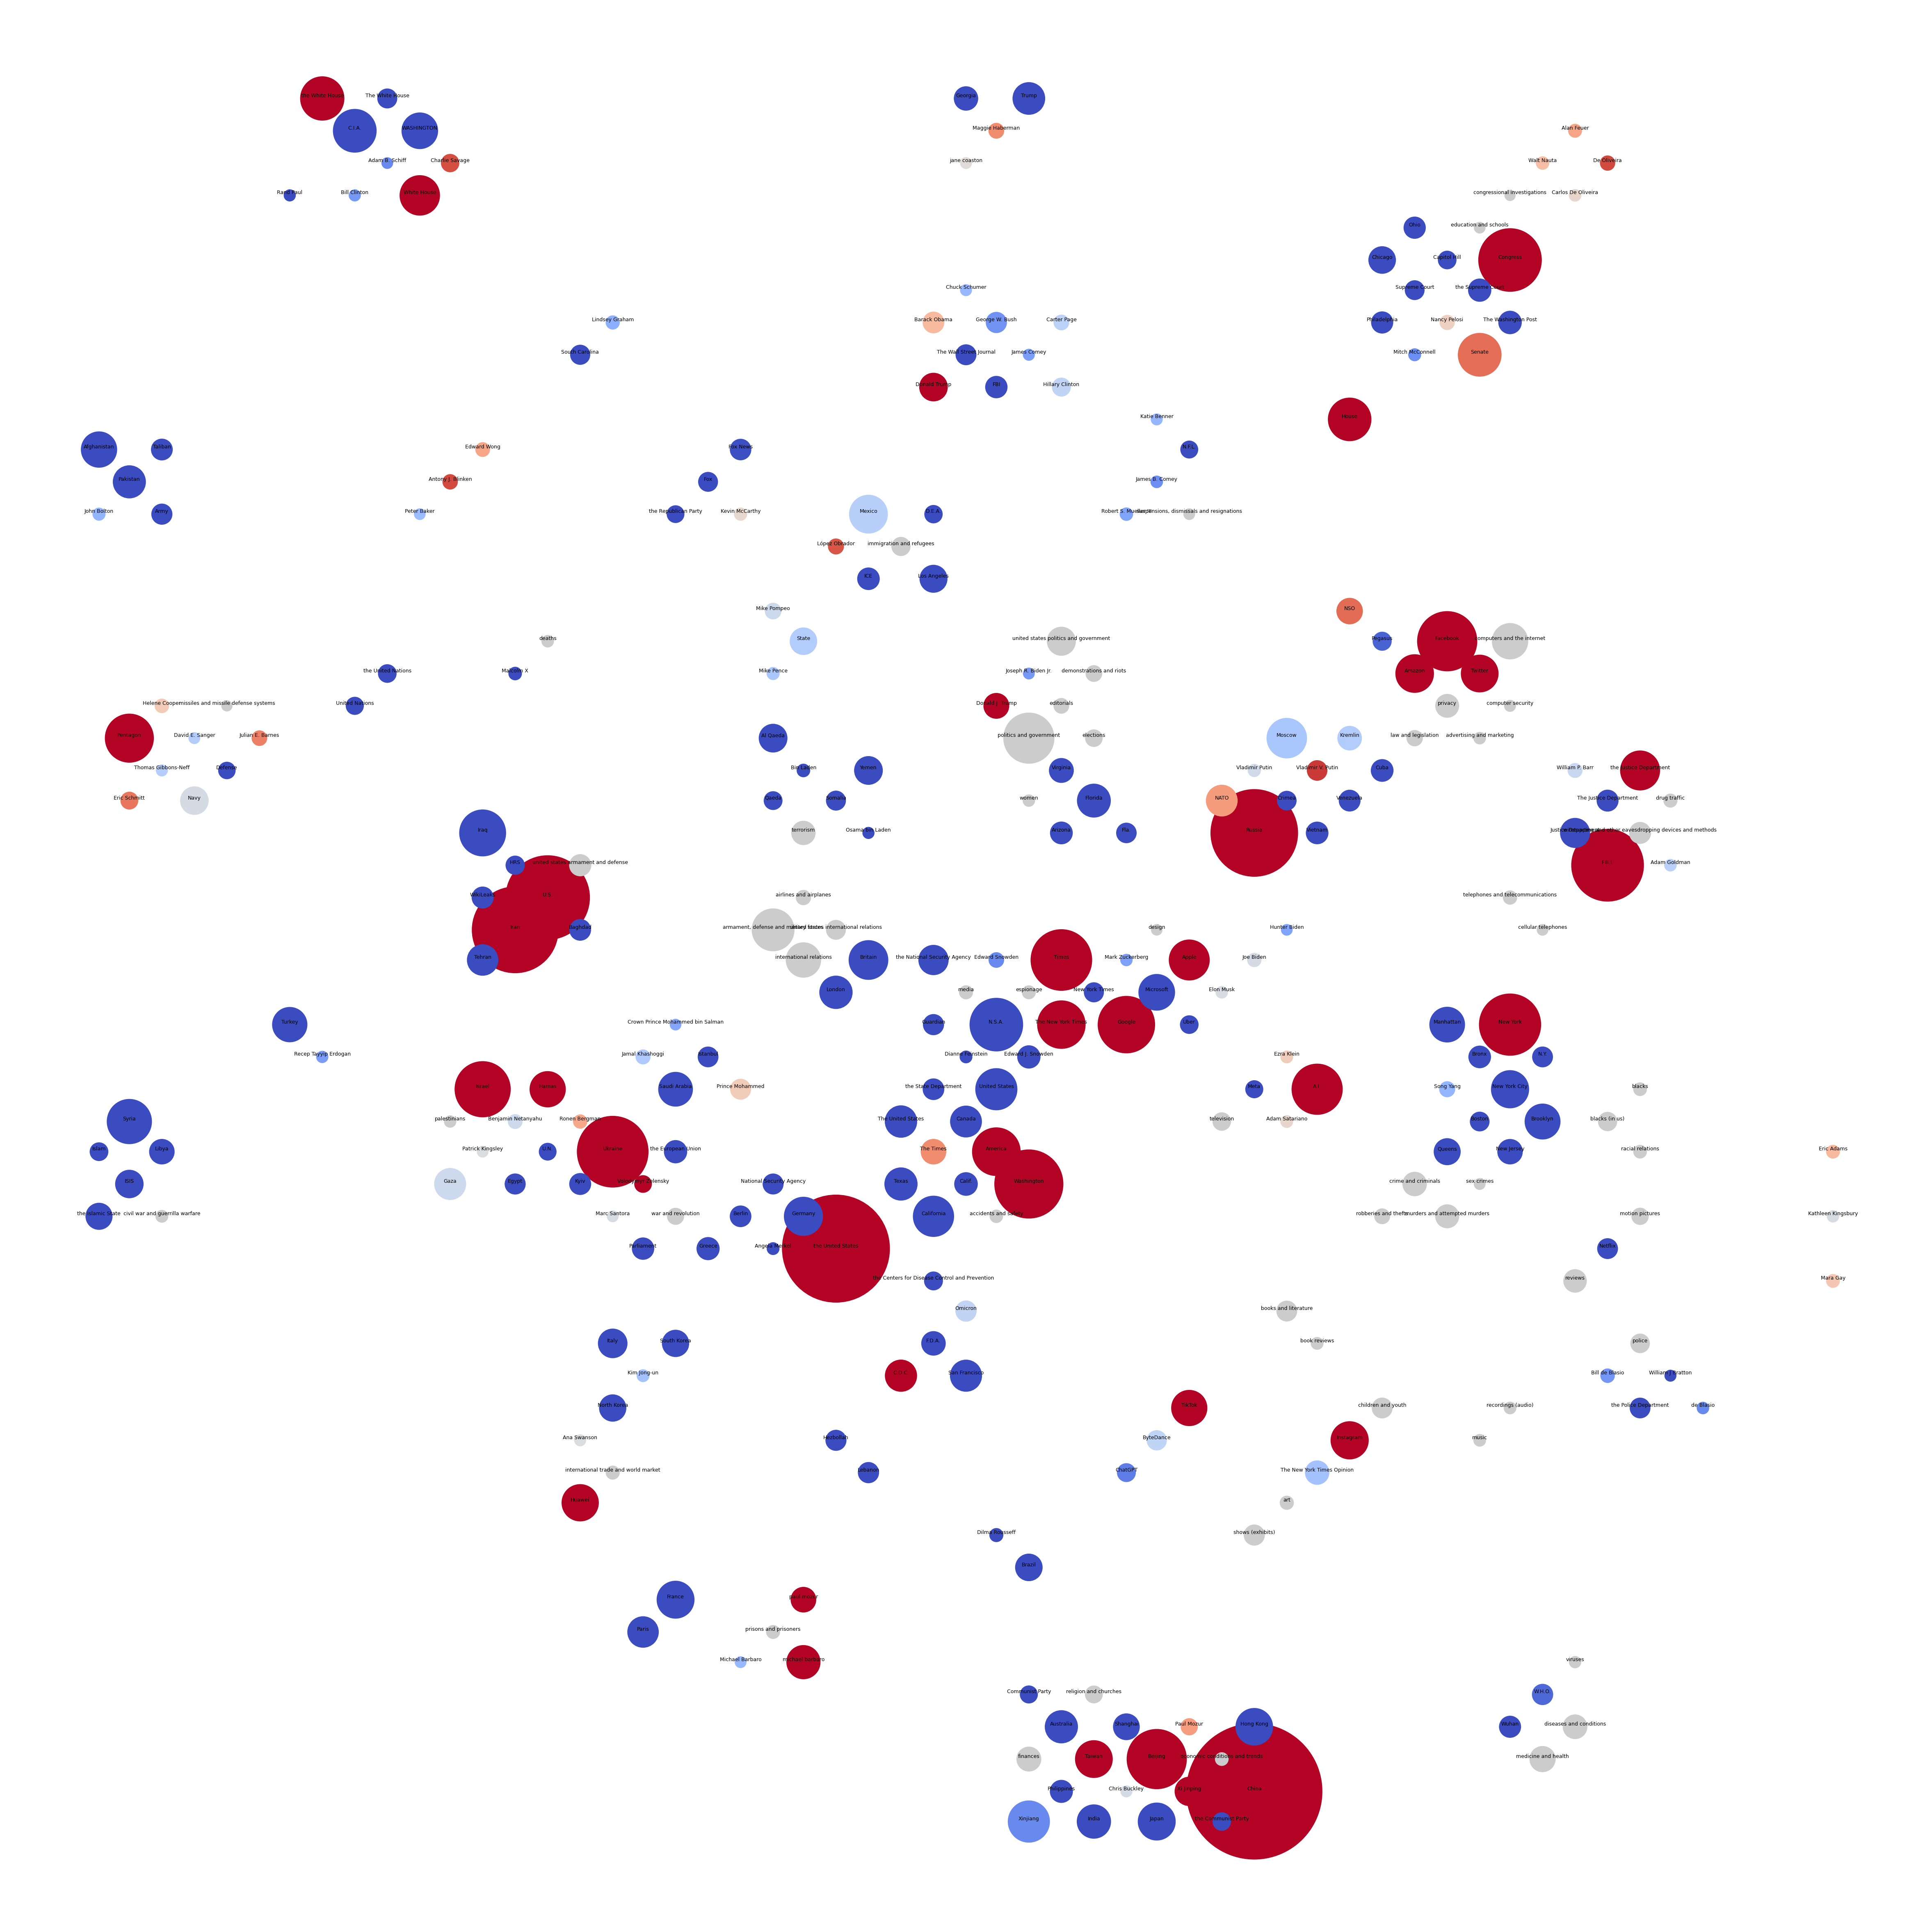

In [31]:
reducer = umap.UMAP(
    random_state=4,
    n_components=2,
    n_neighbors=2,
    min_dist=0.2,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

# entities.sample(1)

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


## Clustering

In [32]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=3,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=10, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            entities.loc[index, "cluster"] = str(clusters[count])


cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] > 0)],
    "p_",
    entities,
)
cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] < 0)],
    "n_",
    entities,
)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
2038,South Korea,gpe,224,-4.388516,#3b4cc0,366,322,n_12,"{'2010': 0, '2011': 4, '2012': 2, '2013': 6, '...",[https://www.nytimes.com/2019/02/07/obituaries...,[Rabbi Yechiel Eckstein Dies at 67; Fostered I...,"[JERUSALEM, Israel, Jerusalem, Israel, Israel,...",0.035985,"{""2010"": 0, ""2011"": 4, ""2012"": 2, ""2013"": 6, ""..."


{'p_4', 'n_14', 'n_13', 'n_3', 'n_16', 'n_7', 'n_10', 'n_4', 'n_18', 'n_8', '-1', 'n_2', 'n_12', 'n_5', 'p_1', 'n_6', 'p_6', 'p_2', 'p_5', 'n_11', 'n_19', 'n_1', 'p_0', 'n_15', 'n_17', 'p_3', 'n_9', 'n_0', 'n_20'}
7
10
7
6
4
14
4
8
6
7
69
5
5
14
3
5
19
6
3
5
8
10
4
16
9
8
5
6
27


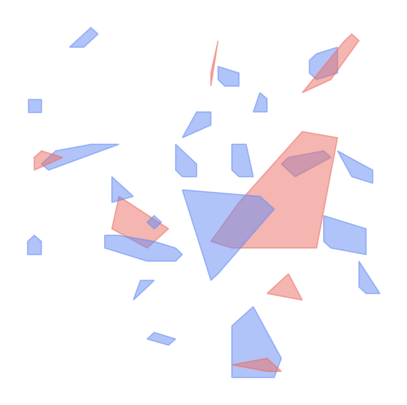

In [33]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [34]:
export = entities.copy()

export = export.drop(columns="years")
export = export.drop(columns="titles")
export = export.drop(columns="cooccurrences")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,name,type,frequency,slope,color,x,y,cluster,urls,frequency_norm,years_JSON
892,Russia,gpe,2526,32.864231,#b40426,633,559,p_6,[https://www.nytimes.com/2018/12/28/us/politic...,0.407455,"{""2010"": 28, ""2011"": 4, ""2012"": 4, ""2013"": 88,..."
